In [1]:
from keras.datasets import cifar100
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import time


In [2]:
image_train=np.load("image_train.npy")
label_train=np.load("label_train.npy")
image_test=np.load("image_test.npy")
label_test=np.load("label_test.npy")

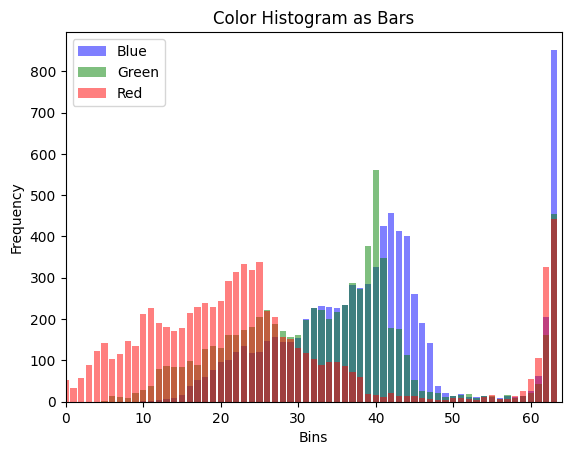

In [3]:
train_b_HG=[]
train_g_HG=[]
train_r_HG=[]
test_b_HG=[]
test_g_HG=[]
test_r_HG=[]

div=64
for image in image_train:
    image_np = np.array(image)
    train_b_HG.append(cv.calcHist([image_np], [2], None, [div], [0, 255]))
    train_g_HG.append(cv.calcHist([image_np], [1], None, [div], [0, 255]))
    train_r_HG.append(cv.calcHist([image_np], [0], None, [div], [0, 255]))

for image in image_test:
    image_np = np.array(image)
    test_b_HG.append(cv.calcHist([image_np], [2], None, [div], [0, 255]))
    test_g_HG.append(cv.calcHist([image_np], [1], None, [div], [0, 255]))
    test_r_HG.append(cv.calcHist([image_np], [0], None, [div], [0, 255]))


train_histograms = [
    np.concatenate((b.flatten(), g.flatten(), r.flatten()))
    for b, g, r in zip(train_b_HG, train_g_HG, train_r_HG)
]
test_histograms = [
    np.concatenate((b.flatten(), g.flatten(), r.flatten()))
    for b, g, r in zip(test_b_HG, test_g_HG, test_r_HG)
]

train_histograms = np.array(train_histograms)
test_histograms = np.array(test_histograms)


plt.xlim([0, div])
img_num = 50


# Plot histogram as usual bars
plt.bar(range(len(train_b_HG[img_num])), train_b_HG[img_num].flatten(), color='b', alpha=0.5, label='Blue')
plt.bar(range(len(train_g_HG[img_num])), train_g_HG[img_num].flatten(), color='g', alpha=0.5, label='Green')
plt.bar(range(len(train_r_HG[img_num])), train_r_HG[img_num].flatten(), color='r', alpha=0.5, label='Red')
plt.title('Color Histogram as Bars')
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [4]:
'''
train_histograms_squr = np.square(train_histograms) #adding nonlinearity to the data
test_histograms_squr = np.square(test_histograms)

train_histograms=np.concatenate((train_histograms,train_histograms_squr),axis=1)
test_histograms=np.concatenate((test_histograms,test_histograms_squr),axis=1)
'''

all_data=np.concatenate((train_histograms,test_histograms),axis=0)
mean=np.mean(all_data,axis=0)
std=np.std(all_data,axis=0)

train_histograms=(train_histograms-mean)/std
test_histograms=(test_histograms-mean)/std

print(train_histograms.shape)
print(test_histograms.shape)


(70491, 192)
(23619, 192)


In [5]:
def k_means(data, k, max_iters=10000, tol=1e-5):
    
    n_samples, _ = data.shape
    # Step 1: Initialize centroids by randomly selecting 'k' points from the data
    centroids = data[np.random.choice(n_samples, k, replace=False)]
    
    for i in range(max_iters):
        T1=time.time()
        # Step 2: Assign each point to the closest centroid
        distances = np.linalg.norm(data[:, None, :] - centroids[None, :, :], axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Step 3: Update centroids by calculating the mean of all points assigned to each centroid
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        error=np.linalg.norm(new_centroids - centroids)
        # Step 4: Check for convergence (if centroids have not changed)
        if error < tol:
            print(error)
            break
        #print norm of difference between new and old centroids
        
        centroids = new_centroids
        print(f'Iteration {i + 1}/{max_iters}')
        T2=time.time()
        print(f'Elapsed time: {T2-T1} seconds')
    return labels, centroids

# Run K-Means clustering on the training histograms
k = 100  # Number of clusters
labels_train, centroids = k_means(train_histograms, k)



Iteration 1/10000
Elapsed time: 38.754088163375854 seconds
Iteration 2/10000
Elapsed time: 9.016261100769043 seconds
Iteration 3/10000
Elapsed time: 8.472337484359741 seconds
Iteration 4/10000
Elapsed time: 6.226847171783447 seconds
Iteration 5/10000
Elapsed time: 5.879421234130859 seconds
Iteration 6/10000
Elapsed time: 5.623154640197754 seconds
Iteration 7/10000
Elapsed time: 5.6188788414001465 seconds
Iteration 8/10000
Elapsed time: 5.736209392547607 seconds
Iteration 9/10000
Elapsed time: 5.589628219604492 seconds
Iteration 10/10000
Elapsed time: 5.160862445831299 seconds
Iteration 11/10000
Elapsed time: 5.339359760284424 seconds
Iteration 12/10000
Elapsed time: 5.3286354541778564 seconds
Iteration 13/10000
Elapsed time: 5.511254072189331 seconds
Iteration 14/10000
Elapsed time: 5.752032279968262 seconds
Iteration 15/10000
Elapsed time: 6.058966398239136 seconds
Iteration 16/10000
Elapsed time: 5.410247087478638 seconds
Iteration 17/10000
Elapsed time: 5.564451217651367 seconds
Ite

In [13]:
# Array to hold the majority class for each cluster (allowing for string labels)
cluster_labels = np.empty(k, dtype=object)  # Use dtype=object for non-numeric labels

for i in range(k):
    # Get indices of data points belonging to cluster `i`
    cluster_indices = np.where(labels_train == i)[0]
    # Get the ground truth labels for these data points
    true_labels = label_train[cluster_indices].flatten()

    # Assign the most frequent label in this cluster to the cluster
    if len(true_labels) > 0:  # Ensure the cluster is not empty
        unique_labels, counts = np.unique(true_labels, return_counts=True)
        cluster_labels[i] = unique_labels[np.argmax(counts)]

# Map each data point's cluster to its corresponding label
predicted_labels = np.array([cluster_labels[label] for label in labels_train])

# Calculate accuracy
accuracy = np.mean(predicted_labels.flatten() == label_train.flatten())
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 61.09%
